In [528]:
import random
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import tsplib95
from utils.get_opt_cost import get_optimal_cost
from data.opt_cost import tsp as opt_sol
from utils.create_distance_matrix import create_distance_matrix

In [529]:
INT_MAX = 2147483647

def rand_num(start, end):
    """Returns a random number in the range [start, end)."""
    return randint(start, end - 1)

def create_gnome(nb_cities):
    """Creates a valid GNOME (tour)."""
    gnome = list(range(nb_cities))
    gnome = random.sample(gnome, len(gnome))  # Shuffle the list
    gnome.append(gnome[0])  # Return to the starting city
    return gnome

def cal_fitness(gnome, distance_matrix):
    """Calculates the fitness value (total cost) of a GNOME."""
    f = 0
    for i in range(len(gnome) - 1):
        city1 = gnome[i]
        city2 = gnome[i + 1]
        if distance_matrix[city1][city2] == INT_MAX:
            return INT_MAX
        f += distance_matrix[city1][city2]
    return f

In [530]:
def initialize_population(nb_cities, pop_size, distance_matrix):
    """Creates the initial population of individuals."""
    population = []
    for _ in range(pop_size):
        gnome = create_gnome(nb_cities)
        fitness = cal_fitness(gnome, distance_matrix)
        population.append({'gnome': gnome, 'fitness': fitness})
    return population

In [531]:
def selection_tournament(population, tourn_size=3):
    """Selects the best individuals from a population using tournament selection."""
    pop_size = len(population)
    fitness_array = np.array([ind['fitness'] for ind in population])
    aspirants_idx = np.random.randint(pop_size, size=(pop_size, tourn_size))  # Select indices for tournaments
    aspirants_values = fitness_array[aspirants_idx]  # Get fitness values of aspirants
    winner_idx = aspirants_values.argmin(axis=1)  # Index of the winner for each tournament (lower fitness is better)
    sel_index = [aspirants_idx[i, j] for i, j in enumerate(winner_idx)]  # Index of the selected individuals
    selected_population = [population[idx] for idx in sel_index]  # Get the winners from the original population
    return selected_population

In [532]:
def apply_crossover(parent1, parent2, distance_matrix):
    """Applies Order Crossover (OX1) to generate offspring."""
    size = len(parent1['gnome']) - 1  # Do not include the last repeated city
    child_gnome = [-1] * size  # Initialize child with placeholders
    start, end = sorted([rand_num(1, size), rand_num(1, size)])
    child_gnome[start:end] = parent1['gnome'][start:end]
    p2_genes = [gene for gene in parent2['gnome'] if gene not in child_gnome]
    i = 0
    for j in range(size):
        if child_gnome[j] == -1:
            child_gnome[j] = p2_genes[i]
            i += 1
    child_gnome.append(child_gnome[0])
    child_fitness = cal_fitness(child_gnome, distance_matrix)
    return {'gnome': child_gnome, 'fitness': child_fitness}

In [533]:
def apply_mutation(population, mutation_rate, distance_matrix):
    """Applies reverse mutation to the entire population."""
    for individual in population:
        if random.random() < mutation_rate:
            Chrom = np.array(individual['gnome'])
            n1, n2 = np.random.randint(0, len(Chrom) - 1, 2)
            if n1 >= n2:
                n1, n2 = n2, n1 + 1
            Chrom[n1:n2] = Chrom[n1:n2][::-1]  # Reverse the segment
            individual['gnome'] = list(Chrom)
            individual['fitness'] = cal_fitness(individual['gnome'], distance_matrix)
    return population

In [534]:
def plot_best_individual(best_fitness):
    generations = list(range(1, len(best_fitness) + 1))
    plt.plot(generations, best_fitness, color='g', label='Best Fitness')
    plt.title('Best Fitness over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid()
    plt.show()


In [535]:
def genetic(distance_matrix, hyperparams=None):

    # Default hyperparameters
    defaults = {
        "POP_SIZE": 200,
        "GEN_THRESH": 500,
        "crossover_rate": 0.7,
        "mutation_rate": 0.3,
    }
    if hyperparams:
        defaults.update(hyperparams)

    nb_cities = len(distance_matrix)
    pop_size = defaults["POP_SIZE"]
    gen_thresh = defaults["GEN_THRESH"]
    crossover_rate = defaults["crossover_rate"]
    mutation_rate = defaults["mutation_rate"]

    best_fitness = []


    # Initialize population
    population = initialize_population(nb_cities, pop_size, distance_matrix)

    # Iterate through generations
    for gen in range(gen_thresh):
        # print(f"\nGeneration {gen + 1}")
        # print all the individuals in the population
        # for i in range(pop_size):
        #     print(f'Fitness: {population[i]["fitness"]} \n Genome: {population[i]["gnome"]}')

        # Sort by fitness
        population.sort(key=lambda x: x['fitness'])

        current_best_fitness = population[0]['fitness']
        best_fitness.append(current_best_fitness)

        current_best_gnome = [int(x + 1) for x in population[0]['gnome']]
        # print(f"Best Fitness: {current_best_fitness}")
        # print(f"Best GNOME:{current_best_gnome}")

        selected_population = selection_tournament(population)
        new_population = []
        for i in range(0, len(selected_population), 2):
            parent1 = selected_population[i]
            parent2 = selected_population[i + 1] if i + 1 < len(selected_population) else parent1
            if random.random() < crossover_rate:
                child = apply_crossover(parent1, parent2, distance_matrix)
                new_population.append(child)

        new_population.extend(selected_population)  # Combine parents and children
        new_population = sorted(new_population, key=lambda x: x['fitness'])[:pop_size]  # Select the best individuals

        new_population = apply_mutation(new_population, mutation_rate, distance_matrix)

        # Update the population
        population = new_population

    # test population
    # for i in range(pop_size):
    #     print(population[i])

    # plot_best_individual(best_fitness)

    best_individual = min(population, key=lambda x: x['fitness'])
    cost = best_individual['fitness']
    seq = [int(x + 1) for x in best_individual['gnome']]
    return cost, seq


In [ ]:
def plot_fitness_vs_generation(distance_matrix):
    """Plots generation threshold vs fitness for different mutation rates."""
    mutation_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
    gen_thresh = range(0, 501, 50)

    for rate in mutation_rates:
        fitness = []
        for thresh in gen_thresh:
            _, cost = genetic(distance_matrix, {"GEN_THRESH": thresh, "mutation_rate": rate})
            fitness.append(cost)
        plt.plot(gen_thresh, fitness, label=f'Mutation Rate: {rate}', marker='x', alpha=0.7)
    plt.title('Random generate 50 cities instance')
    plt.xlabel('Generation Threshold')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid()
    plt.show()

In [536]:
# SEED = 42  # Set a fixed seed for reproducibility
# random.seed(SEED)
# np.random.seed(SEED)

data = "bier127"  # Specify your dataset
problem = tsplib95.load(f'../data/ALL_tsp/{data}.tsp')
distance_matrix = create_distance_matrix(problem)

plot_fitness_vs_generation(distance_matrix)


# hyperparams = {
#     "POP_SIZE": 200,
#     "GEN_THRESH": 5000,
#     "crossover_rate": 0.9,
#     "mutation_rate": 0.3,
# }
#
# cost, seq = genetic(distance_matrix, hyperparams)
# print('\nCost:', cost)
# print('Sequence:', seq)
#
# opt_cost = get_optimal_cost(opt_sol.data, data)
# print("\nOptimal cost:", opt_cost)
# print("\nDeviation:", ((cost - opt_cost) / opt_cost) * 100)


In [537]:
# def objective(trial):
#     params = {
#         "POP_SIZE": trial.suggest_int("POP_SIZE", 150, 300, step=50),
#         "GEN_THRESH": trial.suggest_int("GEN_THRESH", 100, 5000, step=100),
#         "crossover_rate": trial.suggest_float("crossover_rate", 0.5, 1.0),
#         "mutation_rate": trial.suggest_float("mutation_rate", 0.05, 0.3),
#     }
#
#     relative_error = 0
#     cost, seq = genetic(distance_matrix, hyperparams=params)
#     opt_cost = get_optimal_cost(opt_sol.data, data)
#     relative_error += (cost - opt_cost) / opt_cost
#
#     return relative_error


[I 2024-12-13 10:00:05,509] A new study created in memory with name: no-name-f8b7af8b-0d41-4c34-a9f8-0973313209a8


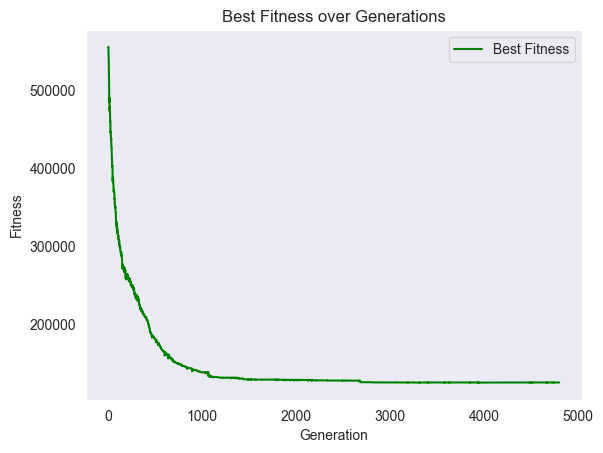

[I 2024-12-13 10:02:30,288] Trial 0 finished with value: 0.05988231514516156 and parameters: {'POP_SIZE': 200, 'GEN_THRESH': 4800, 'crossover_rate': 0.8659969709057025, 'mutation_rate': 0.19966462104925914}. Best is trial 0 with value: 0.05988231514516156.


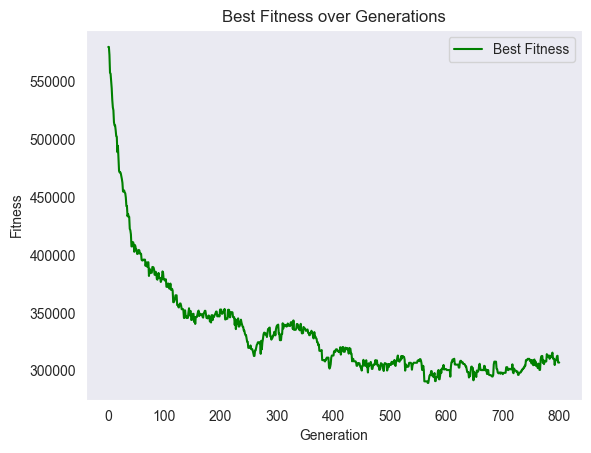

[I 2024-12-13 10:02:42,119] Trial 1 finished with value: 1.5961346612333238 and parameters: {'POP_SIZE': 150, 'GEN_THRESH': 800, 'crossover_rate': 0.5290418060840998, 'mutation_rate': 0.2665440364437338}. Best is trial 0 with value: 0.05988231514516156.
[W 2024-12-13 10:03:00,720] Trial 2 failed with parameters: {'POP_SIZE': 250, 'GEN_THRESH': 3600, 'crossover_rate': 0.5102922471479012, 'mutation_rate': 0.2924774630404986} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/cy/vstztct90b90zhd8ssbmwpgh0000gn/T/ipykernel_37813/3883067865.py", line 10, in objective
    cost, seq = genetic(distance_matrix, hyperparams=params)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/cy/vstztct90b90zhd8ssbm

KeyboardInterrupt: 

In [538]:
# import optuna
# SEED = 42  # Set a fixed seed for reproducibility
#
# # Run optimization
# study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
# study.optimize(objective, n_trials=10)
#
# print("Best hyperparameters:", study.best_params)
# print("Best value:", study.best_value)
#
# import optuna.visualization as vis
#
#
# vis.plot_optimization_history(study).show()
# vis.plot_param_importances(study).show()
# vis.plot_slice(study).show()